# Imports

In [485]:
from io import StringIO

from catboost import CatBoostRegressor, Pool
from glob import glob
from googlesearch import search
from SPARQLWrapper import SPARQLWrapper, JSON
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import re
import pandas as pd
import zipfile

# Merge files into one

In [319]:
df_dot = pd.concat(
    pd.read_csv(zipfile.ZipFile(filename, 'r').open("T_T100D_SEGMENT_US_CARRIER_ONLY.csv")) 
    for filename in glob("/home/tass/database/app_in_the_air/demand_predictions/dot_raw/with_seats*")
)

In [320]:
df_dot["YEAR"].drop_duplicates().sort_values()

0    2011
0    2012
0    2013
0    2014
0    2015
0    2016
0    2017
0    2018
0    2019
0    2020
0    2021
0    2022
Name: YEAR, dtype: int64

# Load dataset

In [321]:
df_dot.shape

(3986656, 13)

In [322]:
df_dot.head(2)

,SEATS,PASSENGERS,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,AIRCRAFT_TYPE,YEAR,MONTH
0,0.0,0.0,WN,Southwest Airlines Co.,15016,STL,"St. Louis, MO",14492,RDU,"Raleigh/Durham, NC",614,2019,6
1,0.0,0.0,5V,Tatonduk Outfitters Limited d/b/a Everts Air A...,10184,AET,"Allakaket, AK",11630,FAI,"Fairbanks, AK",150,2019,8


In [323]:
df_city_names = df_dot["ORIGIN_CITY_NAME"].drop_duplicates()

In [324]:
df_city_names.head(20)

0            St. Louis, MO
1            Allakaket, AK
2          King Salmon, AK
4            Anchorage, AK
33               Aniak, AK
35             Atqasuk, AK
36              Bethel, AK
43             Seattle, WA
45              Barrow, AK
48               Chino, CA
49              Dayton, OH
51          Dillingham, AK
58            Unalaska, AK
59             El Paso, TX
61             Emmonak, AK
64           Fairbanks, AK
69    East Farmingdale, NY
70          Fort Yukon, AK
71              Galena, AK
75             Iliamna, AK
Name: ORIGIN_CITY_NAME, dtype: object

In [325]:
df_dot[["ORIGIN_CITY_NAME", "DEST_CITY_NAME"]].drop_duplicates().shape

(68170, 2)

In [326]:
df_city_names.shape

(1756,)

# State codes

In [327]:
state_codes = """Alabama	AL	Kentucky	KY	Ohio	OH
Alaska	AK	Louisiana	LA	Oklahoma	OK
Arizona	AZ	Maine	ME	Oregon	OR
Arkansas	AR	Maryland	MD	Pennsylvania	PA
American Samoa	AS	Massachusetts	MA	Puerto Rico	PR
California	CA	Michigan	MI	Rhode Island	RI
Colorado	CO	Minnesota	MN	South Carolina	SC
Connecticut	CT	Mississippi	MS	South Dakota	SD
Delaware	DE	Missouri	MO	Tennessee	TN
District of Columbia	DC	Montana	MT	Texas	TX
Florida	FL	Nebraska	NE	Trust Territories	TT
Georgia	GA	Nevada	NV	Utah	UT
Guam	GU	New Hampshire	NH	Vermont	VT
Hawaii	HI	New Jersey	NJ	Virginia	VA
Idaho	ID	New Mexico	NM	Virgin Islands	VI
Illinois	IL	New York	NY	Washington	WA
Indiana	IN	North Carolina	NC	West Virginia	WV
Iowa	IA	North Dakota	ND	Wisconsin	WI
Kansas	KS	Northern Mariana Islands	CM	Wyoming	WY"""

In [328]:
df_state_codes = pd.read_csv(StringIO(state_codes), sep="\t", header=None)

In [329]:
df_two_columns_codes = pd.concat((
    df_state_codes.iloc[:, :2].rename(columns={0: "state", 1: "abbreviation"}), 
    df_state_codes.iloc[:, 2:4].rename(columns={2: "state", 3: "abbreviation"}), 
    df_state_codes.iloc[:, 4:6].rename(columns={4: "state", 5: "abbreviation"})), ignore_index=False) 

In [330]:
full2short = dict(df_two_columns_codes.itertuples(index=False, name=None))

In [331]:
short2full = dict(map(lambda x: (x[1], x[0]), df_two_columns_codes.itertuples(index=False, name=None)))

# Population dataset

In [332]:
df_population = pd.read_csv("/home/tass/database/app_in_the_air/demand_predictions/dot_raw/UNdata_Export_20220412_221849008.csv")

/mnt/envs/env38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [333]:
df_population.head(4)

,Country or Area,Year,Area,Sex,City,City type,Record Type,Reliability,Source Year,Value,Value Footnotes
0,Åland Islands,2020,Total,Both Sexes,MARIEHAMN,City proper,Estimate - de jure,"Final figure, complete",2021.0,11692.0,1
1,Åland Islands,2020,Total,Male,MARIEHAMN,City proper,Estimate - de jure,"Final figure, complete",2021.0,5599.5,1
2,Åland Islands,2020,Total,Female,MARIEHAMN,City proper,Estimate - de jure,"Final figure, complete",2021.0,6092.0,1
3,Åland Islands,2019,Total,Both Sexes,MARIEHAMN,City proper,Estimate - de jure,"Final figure, complete",2020.0,11711.0,1


In [334]:
df_pop_filt = (df_population
                .query("Year == 2020 and Sex == 'Both Sexes'")[["Country or Area", "Area", "City", "Value"]]
              )

In [335]:
df_pop_filt.head(2)

,Country or Area,Area,City,Value
0,Åland Islands,Total,MARIEHAMN,11692.00000
253,Argentina,Total,Bahía Blanca-Cerri,314538.59851


# Join population dataset with cities from DOT

In [336]:
df_city_names.head(4)

0      St. Louis, MO
1      Allakaket, AK
2    King Salmon, AK
4      Anchorage, AK
Name: ORIGIN_CITY_NAME, dtype: object

In [337]:
df_dot_cities = df_city_names.str.split(",", expand=True).rename(columns={0: "city", 1: "state"})

In [338]:
df_dot_cities.shape

(1756, 2)

## unique cities

In [339]:
df_dot_city_unique = df_dot_cities[["city"]].drop_duplicates()

In [340]:
df_dot_city_unique.shape

(1631, 1)

In [341]:
df_pop_unique = df_pop_filt[["City"]].drop_duplicates().rename(columns={"City": "city"})

In [342]:
df_pop_unique.shape

(1205, 1)

In [343]:
df_dot_pop = df_dot_city_unique.merge(df_pop_unique, on="city")

In [344]:
df_dot_pop.shape

(17, 1)

In [345]:
df_dot_pop

,city
0,San Juan
1,Toledo
2,Richmond
3,Georgetown
4,Santa Ana
5,Burlington
6,Victoria
7,Waterloo
8,Rosario
9,Santa Rosa


# the coverage is small. what is wrong?

* Guam, TT

In [346]:
df_population.head(2)

,Country or Area,Year,Area,Sex,City,City type,Record Type,Reliability,Source Year,Value,Value Footnotes
0,Åland Islands,2020,Total,Both Sexes,MARIEHAMN,City proper,Estimate - de jure,"Final figure, complete",2021.0,11692.0,1
1,Åland Islands,2020,Total,Male,MARIEHAMN,City proper,Estimate - de jure,"Final figure, complete",2021.0,5599.5,1


In [347]:
df_clear_pop = df_population.dropna()

In [348]:
df_clear_pop["City"].str.contains("Guam")

0        False
1        False
2        False
3        False
4        False
         ...  
67193    False
67194    False
67195    False
67196    False
67197    False
Name: City, Length: 32873, dtype: bool

In [349]:
(df_clear_pop["City"].str.contains("Guam")).sum()

0

In [350]:
df_pop_00 = pd.read_csv("/home/tass/database/app_in_the_air/demand_predictions/dot_raw/co-est2021-alldata.csv")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf1 in position 107223: invalid continuation byte

In [82]:
sparql = SPARQLWrapper(
    "http://vocabs.ardc.edu.au/repository/api/sparql/"
    "csiro_international-chronostratigraphic-chart_geologic-time-scale-2020"
)
sparql.setReturnFormat(JSON)

# gets the first 3 geological ages
# from a Geological Timescale database,
# via a SPARQL endpoint
sparql.setQuery("""
    PREFIX gts: <http://resource.geosciml.org/ontology/timescale/gts#>

    SELECT *
    WHERE {
        ?a a gts:Age .
    }
    ORDER BY ?a
    LIMIT 3
    """
)

try:
    ret = sparql.queryAndConvert()

    for r in ret["results"]["bindings"]:
        print(r)
except Exception as e:
    print(e)

{'a': {'type': 'uri', 'value': 'http://resource.geosciml.org/classifier/ics/ischart/Aalenian'}}
{'a': {'type': 'uri', 'value': 'http://resource.geosciml.org/classifier/ics/ischart/Aeronian'}}
{'a': {'type': 'uri', 'value': 'http://resource.geosciml.org/classifier/ics/ischart/Albian'}}


In [84]:
for g in search("Guam, TT population", tld="co.in", num=10, stop=10, pause=2):
    print(g)

https://www.worldometers.info/world-population/guam-population/
https://data.worldbank.org/indicator/SP.POP.TOTL?locations=TT
https://data.worldbank.org/indicator/SP.URB.TOTL?locations=TT
https://www.unfpa.org/data/world-population/TT
https://www2.census.gov/library/publications/decennial/1920/bulletins/demographics/census-of-guam.pdf
https://www2.census.gov/prod2/decennial/documents/00476569ch6.pdf
https://www.jstor.org/stable/pdf/198913.pdf
https://www.jstor.org/stable/43620626
https://pubmed.ncbi.nlm.nih.gov/7389543/
https://en.wikipedia.org/wiki/Guam


In [85]:
? search

Signature:
 search(
    query,
    tld='com',
    lang='en',
    tbs='0',
    safe='off',
    num=10,
    start=0,
    stop=None,
    pause=2.0,
    country='',
    extra_params=None,
    user_agent=None,
    verify_ssl=True,
)
Docstring:
Search the given query string using Google.

:param str query: Query string. Must NOT be url-encoded.
:param str tld: Top level domain.
:param str lang: Language.
:param str tbs: Time limits (i.e "qdr:h" => last hour,
    "qdr:d" => last 24 hours, "qdr:m" => last month).
:param str safe: Safe search.
:param int num: Number of results per page.
:param int start: First result to retrieve.
:param int stop: Last result to retrieve.
    Use None to keep searching forever.
:param float pause: Lapse to wait between HTTP requests.
    A lapse too long will make the search slow, but a lapse too short may
    cause Google to block your IP. Your mileage may vary!
:param str country: Country or region to focus the search on. Similar to
    changing the TLD, but d

In [86]:
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
sparql.setQuery("""
    PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>

SELECT ?country ?countryLabel ?population ?totalCityPopulation (?population / ?totalCityPopulation AS ?ratio) {
  ?country wdt:P1082 ?population .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
  {
    SELECT ?country (SUM(?cityPopulation) AS ?totalCityPopulation) WHERE {
      ?city wdt:P31 wd:Q515 .
      ?city wdt:P17 ?country .
      ?city wdt:P1082 ?cityPopulation .
    } GROUP BY ?country
  }
} ORDER BY ?ratio""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

for result in results["results"]["bindings"]:
    print(result)

{'country': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q664'}, 'population': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal', 'type': 'literal', 'value': '5112300'}, 'totalCityPopulation': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal', 'type': 'literal', 'value': '7129260'}, 'countryLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'New Zealand'}, 'ratio': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal', 'type': 'literal', 'value': '0.71708704690248356772'}}
{'country': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q221'}, 'population': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal', 'type': 'literal', 'value': '1836713'}, 'totalCityPopulation': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal', 'type': 'literal', 'value': '2121335'}, 'countryLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'North Macedonia'}, 'ratio': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal', 'type': 'literal', 'value': '0.8658

# 3 ways to move forward:

* make sparql queries to get table of USA cities with their populations
* analize DOT data and population data, why they do not match
* try to query google and take population data from google results

## why DOT data doesn't match population data?

In [351]:
df_population.head(2)

,Country or Area,Year,Area,Sex,City,City type,Record Type,Reliability,Source Year,Value,Value Footnotes
0,Åland Islands,2020,Total,Both Sexes,MARIEHAMN,City proper,Estimate - de jure,"Final figure, complete",2021.0,11692.0,1
1,Åland Islands,2020,Total,Male,MARIEHAMN,City proper,Estimate - de jure,"Final figure, complete",2021.0,5599.5,1


In [352]:
df_usa_population = df_population.query('`Country or Area` == "United States of America"')

In [353]:
df_usa_population.shape

(4275, 11)

In [354]:
df_usa_population_cities = df_usa_population["City"].drop_duplicates()

### Check coverage for DOT cities

In [355]:
df_city_names.head(2)

0    St. Louis, MO
1    Allakaket, AK
Name: ORIGIN_CITY_NAME, dtype: object

In [356]:
lst_dot_cities = df_city_names.to_list()

In [357]:
df_usa_population_cities.head(2)

62313    Abilene (TX)
62314      Akron (OH)
Name: City, dtype: object

In [358]:
lst_population_cities = df_usa_population_cities.to_list()

In [359]:
lst_population_cities[0]

'Abilene (TX)'

In [360]:
lst_dot_cities[0]

'St. Louis, MO'

## try to match

In [361]:
sre = r"([^(]*) \((.*)\)"
t = re.compile(sre)  # \([~\(]\)*\((.*)\)
g = t.match(lst_population_cities[0])
g.groups()

('Abilene', 'TX')

In [362]:
g[2]

'TX'

In [363]:
def comma_sep(m):
    return f"{m[1]}, {m[2]}"

In [364]:
df_usa_population_cities.str.replace(pat=t, repl=comma_sep)

62313        Abilene, TX
62314          Akron, OH
62315    Albuquerque, NM
62316     Alexandria, VA
62317          Allen, TX
              ...       
62937          Vista, CA
63331           Erie, PA
64855     Portsmouth, VA
65582           Gary, IN
65639        Livonia, MI
Name: City, Length: 344, dtype: object

In [365]:
df_usa_population.head(2)

,Country or Area,Year,Area,Sex,City,City type,Record Type,Reliability,Source Year,Value,Value Footnotes
62313,United States of America,2020,Total,Both Sexes,Abilene (TX),City proper,Census - de jure - complete tabulation,"Final figure, complete",2021.0,125182.0,NaN
62314,United States of America,2020,Total,Both Sexes,Akron (OH),City proper,Census - de jure - complete tabulation,"Final figure, complete",2021.0,190469.0,NaN


In [366]:
df_usa_population = df_usa_population.assign(comma_city=df_usa_population["City"].str.replace(pat=t, repl=comma_sep))

In [367]:
df_usa_population.shape

(4275, 12)

In [368]:
df_usa_population["comma_city"].drop_duplicates().shape

(344,)

In [369]:
df_usa_population["comma_city"].drop_duplicates().head(2)

62313    Abilene, TX
62314      Akron, OH
Name: comma_city, dtype: object

In [370]:
df_usa_population.query("comma_city == 'Abilene, TX'")

,Country or Area,Year,Area,Sex,City,City type,Record Type,Reliability,Source Year,Value,Value Footnotes,comma_city
62313,United States of America,2020,Total,Both Sexes,Abilene (TX),City proper,Census - de jure - complete tabulation,"Final figure, complete",2021.0,125182.0,NaN,"Abilene, TX"
62650,United States of America,2016,Total,Both Sexes,Abilene (TX),City proper,Estimate - de jure,"Final figure, complete",2017.0,122225.0,"193,194","Abilene, TX"
62953,United States of America,2015,Total,Both Sexes,Abilene (TX),City proper,Estimate - de jure,"Final figure, complete",2016.0,121721.0,"193,194","Abilene, TX"
63255,United States of America,2012,Total,Both Sexes,Abilene (TX),City proper,Estimate - de jure,"Final figure, complete",2014.0,118887.0,"193,194","Abilene, TX"
63539,United States of America,2010,Total,Both Sexes,Abilene (TX),City proper,Census - de jure - complete tabulation,"Final figure, complete",2013.0,117063.0,"194,195","Abilene, TX"
63821,United States of America,2010,Total,Male,Abilene (TX),City proper,Census - de jure - complete tabulation,"Final figure, complete",2013.0,59107.0,"194,195","Abilene, TX"
64103,United States of America,2010,Total,Female,Abilene (TX),City proper,Census - de jure - complete tabulation,"Final figure, complete",2013.0,57956.0,"194,195","Abilene, TX"
64385,United States of America,2009,Total,Both Sexes,Abilene (TX),City proper,Estimate - de jure,"Final figure, complete",2011.0,117180.0,"194,195","Abilene, TX"
64661,United States of America,2008,Total,Both Sexes,Abilene (TX),City proper,Estimate - de jure,"Final figure, complete",2009.0,116484.0,"194,195","Abilene, TX"
64934,United States of America,2007,Total,Both Sexes,Abilene (TX),City proper,Estimate - de jure,"Final figure, complete",2008.0,116219.0,"194,195","Abilene, TX"


In [371]:
df_latest_population = df_usa_population.query("`Source Year` == 2021")

In [372]:
df_latest_population.shape

(337, 12)

In [373]:
df_population = df_latest_population[["comma_city", "Value"]].rename(columns={"Value": "population", "comma_city": "city"})

In [374]:
df_population.head(2)

,city,population
62313,"Abilene, TX",125182.0
62314,"Akron, OH",190469.0


In [375]:
df_unique_cities = df_dot[["ORIGIN_CITY_NAME"]].drop_duplicates().rename(columns={"ORIGIN_CITY_NAME": "city"})
df_unique_cities.shape

(1756, 1)

## How many cityes are covered with population data

In [376]:
df_covered = df_unique_cities.merge(df_population, on="city")

In [377]:
df_covered.shape

(178, 2)

In [378]:
df_covered.head(20)

,city,population
0,"St. Louis, MO",301578.0
1,"Anchorage, AK",291247.0
2,"Seattle, WA",737015.0
3,"Dayton, OH",137644.0
4,"El Paso, TX",678815.0
5,"Laredo, TX",255205.0
6,"Detroit, MI",639111.0
7,"Amarillo, TX",200393.0
8,"Atlanta, GA",498715.0
9,"Hartford, CT",121054.0


In [379]:
df_diagnose = df_unique_cities.merge(pd.concat((df_population, df_manual_population)), how='outer', on='city', indicator=True)

In [380]:
df_diagnose.head(2)

,city,population,_merge
0,"St. Louis, MO",301578.0,both
1,"Allakaket, AK",NaN,left_only


In [381]:
df_diagnose.groupby("_merge").size()

_merge
left_only     1574
right_only     159
both           182
dtype: int64

In [382]:
df_diagnose.query("_merge == 'left_only'").head(10)

,city,population,_merge
1,"Allakaket, AK",NaN,left_only
2,"King Salmon, AK",NaN,left_only
4,"Aniak, AK",NaN,left_only
5,"Atqasuk, AK",NaN,left_only
6,"Bethel, AK",NaN,left_only
8,"Barrow, AK",NaN,left_only
9,"Chino, CA",NaN,left_only
11,"Dillingham, AK",NaN,left_only
12,"Unalaska, AK",NaN,left_only
14,"Emmonak, AK",NaN,left_only


In [383]:
df_diagnose.query("_merge == 'right_only'").head(10)

,city,population,_merge
1756,"Alexandria, VA",159467.0,right_only
1757,"Allen, TX",104627.0,right_only
1758,"Allentown, PA",125845.0,right_only
1759,"Anaheim, CA",346824.0,right_only
1760,"Antioch, CA",115291.0,right_only
1761,"Arlington, VA",238643.0,right_only
1762,"Arvada, CO",124402.0,right_only
1763,"Bellevue, WA",151854.0,right_only
1764,"Berkeley, CA",124321.0,right_only
1765,"Boise City, ID",235684.0,right_only


# manual input

In [384]:
df_manual_population = pd.DataFrame(
    data = (
        ("Guam, TT", 168801),
        ("Rota, TT", 1893),
        ("Saipan, TT", 45565),
        ("Ketchikan, AK", 8192),
        
    ),
    columns=["city", "population"]
)

## correspondence between airports and cities

In [385]:
df_airports_cities = df_dot[["ORIGIN", "ORIGIN_CITY_NAME"]].drop_duplicates().rename(columns={"ORIGIN": "airport", "ORIGIN_CITY_NAME": "city"})

In [386]:
df_airports_cities.shape

(1973, 2)

In [387]:
df_airports_cities.merge(pd.concat((df_population, df_manual_population)), how='outer', on='city', indicator=True).query("_merge == 'left_only'").head(10)

,airport,city,population,_merge
3,AET,"Allakaket, AK",NaN,left_only
4,AKN,"King Salmon, AK",NaN,left_only
9,ANI,"Aniak, AK",NaN,left_only
10,ATK,"Atqasuk, AK",NaN,left_only
11,BET,"Bethel, AK",NaN,left_only
15,BRW,"Barrow, AK",NaN,left_only
16,CNO,"Chino, CA",NaN,left_only
20,DLG,"Dillingham, AK",NaN,left_only
21,DUT,"Unalaska, AK",NaN,left_only
24,EMK,"Emmonak, AK",NaN,left_only


## how many city markets we have in DOT dataset

In [388]:
df_dot[["ORIGIN_CITY_NAME", "DEST_CITY_NAME"]].drop_duplicates().shape

(68170, 2)

# how many city markets we will have after joining origin and destination cities with our population data

In [389]:
df_dot.head(2)

,SEATS,PASSENGERS,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,AIRCRAFT_TYPE,YEAR,MONTH
0,0.0,0.0,WN,Southwest Airlines Co.,15016,STL,"St. Louis, MO",14492,RDU,"Raleigh/Durham, NC",614,2019,6
1,0.0,0.0,5V,Tatonduk Outfitters Limited d/b/a Everts Air A...,10184,AET,"Allakaket, AK",11630,FAI,"Fairbanks, AK",150,2019,8


In [390]:
df_dot_from = df_dot.merge(df_population, left_on="ORIGIN_CITY_NAME", right_on="city").rename(columns={"population": "population_from"})
df_dot_from_to = df_dot_from.merge(df_population, left_on="DEST_CITY_NAME", right_on="city").rename(columns={"population": "population_to"})

In [391]:
df_dot_from_to.head(2)

,SEATS,PASSENGERS,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,AIRCRAFT_TYPE,YEAR,MONTH,city_x,population_from,city_y,population_to
0,0.0,0.0,YV,Mesa Airlines Inc.,15016,STL,"St. Louis, MO",13198,MCI,"Kansas City, MO",673,2019,5,"St. Louis, MO",301578.0,"Kansas City, MO",508090.0
1,0.0,0.0,5X,United Parcel Service,15016,STL,"St. Louis, MO",13198,MCI,"Kansas City, MO",622,2019,1,"St. Louis, MO",301578.0,"Kansas City, MO",508090.0


In [392]:
df_dot_from_to.shape

(1974925, 17)

In [393]:
df_dot.shape

(3986656, 13)

In [394]:
df_dot_from_to[["ORIGIN_CITY_NAME", "DEST_CITY_NAME"]].drop_duplicates().shape

(13283, 2)

# Simple things to do

* rank markets by the seasonality force
* plot a graph with different types of seasonality
* prepare simple factors
  * (city, city) -> distance
  * (city, city) -> population
* predict load factor  

# Rank markets by seasonality force

## filter out zero passengers and zero seats

In [409]:
df_dot_nonzero = df_dot_from_to.query("PASSENGERS > 0 and SEATS > 0").rename(
    columns={"PASSENGERS": "passengers", "ORIGIN_CITY_NAME": "origin", "DEST_CITY_NAME": "destination", "YEAR": "year", 
             "MONTH": "month", "population_from": "origin_population", "population_to": "destination_population", 
             "ORIGIN_AIRPORT_ID": "origin_airport_id", "DEST_AIRPORT_ID": "destination_airport_id",
             "SEATS": "seats",
            }
)[["year", "month", "origin", "destination", "origin_airport_id", "destination_airport_id", 
   "origin_population", "destination_population", "passengers", "seats"]]

In [410]:
df_dot_nonzero.head(10).T

,2,3,4,5,6,7,8,9,10,11
year,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019
month,10,1,8,6,1,8,1,2,5,6
origin,"St. Louis, MO","St. Louis, MO","St. Louis, MO","St. Louis, MO","St. Louis, MO","St. Louis, MO","St. Louis, MO","St. Louis, MO","St. Louis, MO","St. Louis, MO"
destination,"Kansas City, MO","Kansas City, MO","Kansas City, MO","Kansas City, MO","Kansas City, MO","Kansas City, MO","Kansas City, MO","Kansas City, MO","Kansas City, MO","Kansas City, MO"
origin_airport_id,15016,15016,11123,15016,15016,15016,15016,15016,15016,15016
destination_airport_id,13198,13198,13341,13198,13198,13198,13198,13198,13198,13198
origin_population,301578.0,301578.0,301578.0,301578.0,301578.0,301578.0,301578.0,301578.0,301578.0,301578.0
destination_population,508090.0,508090.0,508090.0,508090.0,508090.0,508090.0,508090.0,508090.0,508090.0,508090.0
passengers,46.0,39.0,39.0,71.0,54.0,65.0,72.0,58.0,116.0,152.0
seats,50.0,70.0,72.0,76.0,76.0,76.0,99.0,110.0,128.0,157.0


## Distance between cities

In [273]:
df_city_airports_distance = df_dot_nonzero[["origin", "destination", "origin_airport_id", "destination_airport_id", "distance"]]

In [274]:
df_city_airports_distance.shape

(1956206, 5)

In [275]:
df_city_airports_distance_un = df_city_airports_distance.drop_duplicates()
df_city_airports_distance_un.shape

(16638, 5)

### Do we have unique key ["origin", "destination", "origin_airport_id", "destination_airport_id"] ?

In [277]:
df_city_airports_distance_un[["origin", "destination", "origin_airport_id", "destination_airport_id"]].drop_duplicates().shape

(14782, 4)

### No, we don't. It's weird. So, we have some pairs "origin_airport_id", "destination_airport_id" with non-equal distances. Let's try to find them.

In [292]:
df_std_airports = (df_city_airports_distance[["origin_airport_id", "destination_airport_id", "distance"]]
                   .groupby(["origin_airport_id", "destination_airport_id"])
                   .std()
                   .rename(columns={"distance": "std_distance"})
                  )

In [293]:
df_std_airports.head(2)

std_distance
origin_airport_id destination_airport_id              
10136             10140                            NaN
                  10155                            0.0

### Just great. We have some nan in our table. Lets figure out how we got them.

In [294]:
df_nan = df_dot_nonzero.isna()

In [295]:
df_nan.head(2)

,year,month,origin,destination,origin_airport_id,destination_airport_id,origin_population,destination_population,passengers,distance
31,False,False,False,False,False,False,False,False,False,False
32,False,False,False,False,False,False,False,False,False,False


In [296]:
df_nan.sum()

year                      0
month                     0
origin                    0
destination               0
origin_airport_id         0
destination_airport_id    0
origin_population         0
destination_population    0
passengers                0
distance                  0
dtype: int64

### There is no nan in table. Nan is for groups with one record only. We can safely filter them out 

In [297]:
df_std_airports.shape

(14782, 1)

In [298]:
df_std_airports.dropna(inplace=True)

In [299]:
df_std_airports.shape

(10863, 1)

In [300]:
df_std_airports.head(2)

std_distance
origin_airport_id destination_airport_id              
10136             10155                       0.000000
                  10279                       0.403113

<AxesSubplot:>

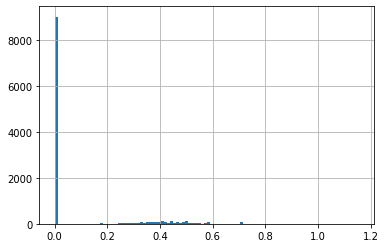

In [302]:
df_std_airports["std_distance"].hist(bins=100)

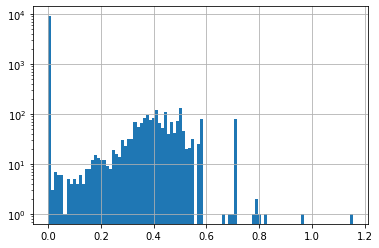

In [305]:
df_std_airports["std_distance"].hist(bins=100)
plt.yscale("log")

## I'm not quite happy with this result because I expected just the same distance between two airports, but 0.4 km looks like negligible deviation

## Factor: Mean distance between two cities

In [308]:
df_city_distance = (df_city_airports_distance[["origin", "destination", "distance"]]
 .groupby(["origin", "destination"], as_index=False)["distance"].mean()
)

In [309]:
df_city_distance.head(10).T

,0,1,2,3,4,5,6,7,8,9
origin,"Abilene, TX","Abilene, TX","Abilene, TX","Abilene, TX","Abilene, TX","Abilene, TX","Abilene, TX","Abilene, TX","Abilene, TX","Abilene, TX"
destination,"Albuquerque, NM","Amarillo, TX","Atlanta, GA","Austin, TX","Birmingham, AL","Brownsville, TX","Burbank, CA","Colorado Springs, CO","Columbus, GA","Corpus Christi, TX"
distance,438.0,226.1875,889.0,194.0,755.0,468.0,1086.0,523.0,861.0,345.0


In [310]:
df_city_distance.shape

(11558, 3)

In [311]:
df_city_distance["origin"].drop_duplicates().shape

(173,)

In [312]:
df_city_distance["destination"].drop_duplicates().shape

(171,)

In [400]:
df_city_distance.to_parquet("/home/tass/database/app_in_the_air/demand_predictions/dot_raw/city_distances")

### Results: 173 cities, 11558 city markets

## Join city distances

In [411]:
df_dot_with_distances = df_dot_nonzero.merge(df_city_distance, on=["origin", "destination"])

In [412]:
df_dot_with_distances.head(2)

,year,month,origin,destination,origin_airport_id,destination_airport_id,origin_population,destination_population,passengers,seats,distance
0,2019,10,"St. Louis, MO","Kansas City, MO",15016,13198,301578.0,508090.0,46.0,50.0,236.799639
1,2019,1,"St. Louis, MO","Kansas City, MO",15016,13198,301578.0,508090.0,39.0,70.0,236.799639


In [413]:
df_dot_with_distances.shape

(1694552, 11)

## Factor: origin and destination population

In [414]:
df_dot_with_distances.head(2).T

,0,1
year,2019,2019
month,10,1
origin,"St. Louis, MO","St. Louis, MO"
destination,"Kansas City, MO","Kansas City, MO"
origin_airport_id,15016,15016
destination_airport_id,13198,13198
origin_population,301578.0,301578.0
destination_population,508090.0,508090.0
passengers,46.0,39.0
seats,50.0,70.0


### We already have, no need to recalculate.

# Predict load factor for a market

## The idea

### We have load factor of passengers/seats. Hypothesis is that there is a correlation between geographical parameters of markets and the load factor of a market

## Average load factor for 2019

In [416]:
df_group_seats_passengers = df_dot_with_distances.query("year == 2019")[["origin", "destination", "passengers", "seats"]].groupby(["origin", "destination"], as_index=False).sum()

In [417]:
df_group_seats_passengers = df_group_seats_passengers.assign(load_factor=df_group_seats_passengers["passengers"] / df_group_seats_passengers["seats"])

<AxesSubplot:ylabel='Frequency'>

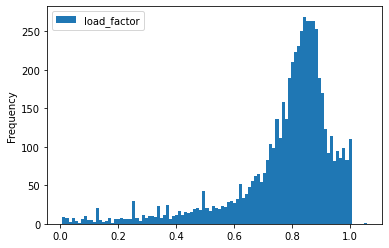

In [422]:
df_group_seats_passengers.plot(y="load_factor", kind="hist", bins=100)

In [423]:
df_group_seats_passengers.head(2).T

,0,1
origin,"Abilene, TX","Abilene, TX"
destination,"Austin, TX","Dallas, TX"
passengers,168.0,49.0
seats,310.0,143.0
load_factor,0.541935,0.342657


In [424]:
df_population.head(2).T

,62313,62314
city,"Abilene, TX","Akron, OH"
population,125182.0,190469.0


In [442]:
df_dataset = (df_group_seats_passengers              
              .merge(df_population, left_on="origin", right_on="city").rename(columns={"population": "population_origin"})
              .merge(df_population, left_on="destination", right_on="city").rename(columns={"population": "population_destination"}) 
              .drop(columns=["city_x", "city_y"])
              .merge(df_city_distance, on=["origin", "destination"])
             )

In [443]:
df_dataset.head(2).T

,0,1
origin,"Abilene, TX","Akron, OH"
destination,"Austin, TX","Austin, TX"
passengers,168.0,121.0
seats,310.0,126.0
load_factor,0.541935,0.960317
population_origin,125182.0,190469.0
population_destination,961855.0,961855.0
distance,194.0,1172.0


In [444]:
df_dataset.shape

(5714, 8)

In [446]:
df_dataset.set_index(["origin", "destination"], inplace=True)

In [447]:
df_dataset.head(2)

,,passengers,seats,load_factor,population_origin,population_destination,distance
origin,destination,,,,,,
"Abilene, TX","Austin, TX",168.0,310.0,0.541935,125182.0,961855.0,194.0
"Akron, OH","Austin, TX",121.0,126.0,0.960317,190469.0,961855.0,1172.0


In [449]:
df_to_learn = df_dataset[["population_origin", "population_destination", "distance", "load_factor"]]

In [450]:
df_to_learn.head(2)

,,population_origin,population_destination,distance,load_factor
origin,destination,,,,
"Abilene, TX","Austin, TX",125182.0,961855.0,194.0,0.541935
"Akron, OH","Austin, TX",190469.0,961855.0,1172.0,0.960317


In [452]:
x_train, x_test, y_train, y_test = train_test_split(df_to_learn[["population_origin", "population_destination", "distance"]], df_to_learn[["load_factor"]])

In [454]:
x_train.head(2)

,,population_origin,population_destination,distance
origin,destination,,,
"Columbia, SC","Knoxville, TN",136632.0,190740.0,208.0
"Minneapolis, MN","Milwaukee, WI",429954.0,577222.0,297.0


In [455]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4285, 3), (1429, 3), (4285, 1), (1429, 1))

In [465]:
? CatBoostRegressor

Init signature:
 CatBoostRegressor(
    iterations=None,
    learning_rate=None,
    depth=None,
    l2_leaf_reg=None,
    model_size_reg=None,
    rsm=None,
    loss_function='RMSE',
    border_count=None,
    feature_border_type=None,
    per_float_feature_quantization=None,
    input_borders=None,
    output_borders=None,
    fold_permutation_block=None,
    od_pval=None,
    od_wait=None,
    od_type=None,
    nan_mode=None,
    counter_calc_method=None,
    leaf_estimation_iterations=None,
    leaf_estimation_method=None,
    thread_count=None,
    random_seed=None,
    use_best_model=None,
    best_model_min_trees=None,
    verbose=None,
    silent=None,
    logging_level=None,
    metric_period=None,
    ctr_leaf_count_limit=None,
    store_all_simple_ctr=None,
    max_ctr_complexity=None,
    has_time=None,
    allow_const_label=None,
    target_border=None,
    one_hot_max_size=None,
    random_strength=None,
    name=None,
    ignored_features=None,
    train_dir=None,
    cu

In [498]:
clf = CatBoostRegressor(iterations=10000)

In [500]:
clf.fit(X=x_train, y=y_train, eval_set=(x_test, y_test), metric_period=1000, plot=True, use_best_model=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.008788
0:	learn: 0.1757169	test: 0.1807547	best: 0.1807547 (0)	total: 2.04ms	remaining: 20.4s
1000:	learn: 0.1615922	test: 0.1742510	best: 0.1742510 (1000)	total: 1.08s	remaining: 9.7s
2000:	learn: 0.1522644	test: 0.1721704	best: 0.1721704 (2000)	total: 2.13s	remaining: 8.53s
3000:	learn: 0.1450636	test: 0.1710976	best: 0.1710976 (3000)	total: 3.17s	remaining: 7.39s
4000:	learn: 0.1390236	test: 0.1704585	best: 0.1704585 (4000)	total: 4.27s	remaining: 6.4s
5000:	learn: 0.1335664	test: 0.1703218	best: 0.1703218 (5000)	total: 5.35s	remaining: 5.34s
6000:	learn: 0.1287860	test: 0.1703503	best: 0.1703218 (5000)	total: 6.39s	remaining: 4.26s
7000:	learn: 0.1243578	test: 0.1705330	best: 0.1703218 (5000)	total: 7.41s	remaining: 3.17s
8000:	learn: 0.1203349	test: 0.1706928	best: 0.1703218 (5000)	total: 8.41s	remaining: 2.1s
9000:	learn: 0.1167337	test: 0.1709419	best: 0.1703218 (5000)	total: 9.42s	remaining: 1.04s
9999:	learn: 0.1134316	test: 0.1711457	best: 0.1703218 (50

<AxesSubplot:>

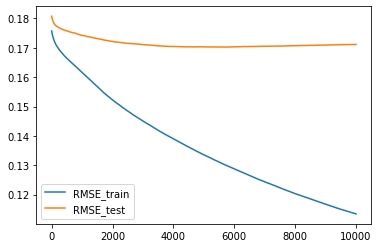

In [507]:
ax = pd.DataFrame(clf.eval_metrics(Pool(x_train, y_train), metrics=["RMSE"])).rename(columns={"RMSE": "RMSE_train"}).plot()
pd.DataFrame(clf.eval_metrics(Pool(x_test, y_test), metrics=["RMSE"])).rename(columns={"RMSE": "RMSE_test"}).plot(ax=ax)

<AxesSubplot:>

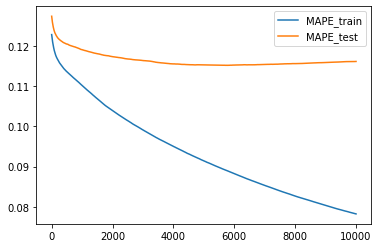

In [508]:
ax = pd.DataFrame(clf.eval_metrics(Pool(x_train, y_train), metrics=["MAPE"])).rename(columns={"MAPE": "MAPE_train"}).plot()
pd.DataFrame(clf.eval_metrics(Pool(x_test, y_test), metrics=["MAPE"])).rename(columns={"MAPE": "MAPE_test"}).plot(ax=ax)

In [514]:
clf.get_feature_importance(Pool(x_train, y_train, feature_names=list(x_train.columns)))

array([36.92949973, 35.39822524, 27.67227503])

In [515]:
x_train.head(2)

,,population_origin,population_destination,distance
origin,destination,,,
"Columbia, SC","Knoxville, TN",136632.0,190740.0,208.0
"Minneapolis, MN","Milwaukee, WI",429954.0,577222.0,297.0


## Predict low 5%